In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score

from synexp import *
from viz import *


/Users/lguerdan/.virtualenvs/10701-Project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

- $X \in [-1, 1]$ is a unidimensional co-variate
- Target potential outcome (PO) class probabilities $\eta^*_0(x), \eta^*_1(x)$ are piecewise sinusoidal functions satisfying weak seperability

- $\pi(x)=.2 x +.4$ is linear and correlated with $\eta^*_0(x)$. Specifically, cases at high risk under no intervention are also most likely to receive intervention

- Error parameters sampled randomly $\alpha_d, \beta_d \sim U(.01,.24)$

<!-- 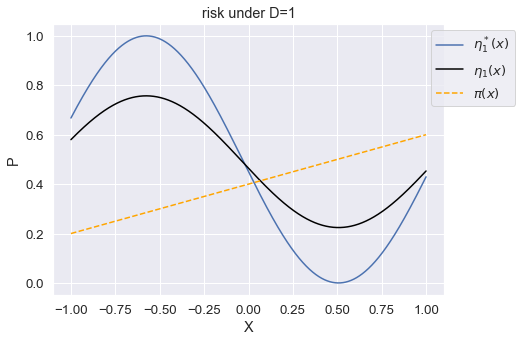 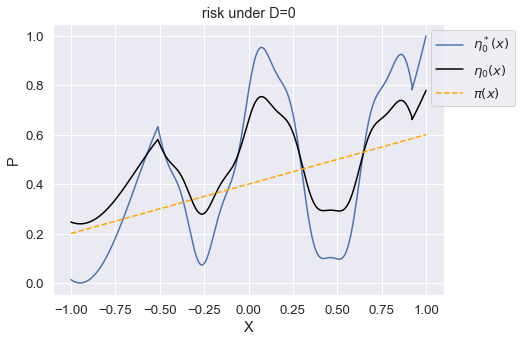  -->

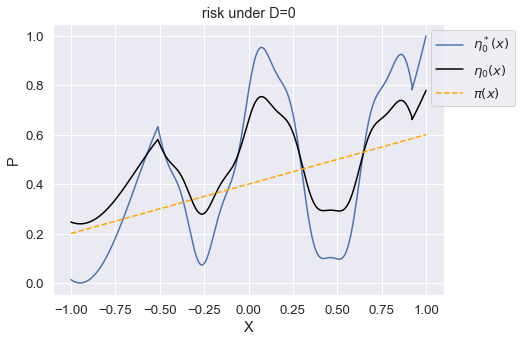
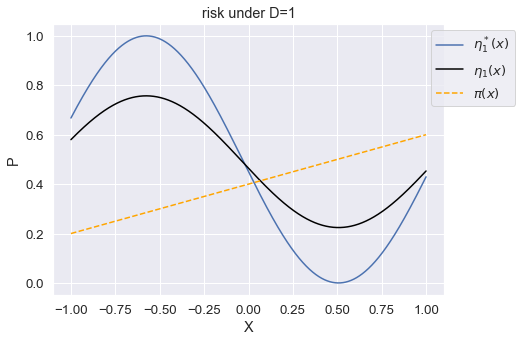

 
### Data generating process:

1. $Y^*_0, Y^*_1 \sim $ Bern($\eta^*_0(x)$), Bern($\eta^*_1(x)$), $\forall x \in X$
2. Sample errors $\alpha_d, \beta_d \sim U(.01,.24) \forall d \in D$
3. Flip $Y^*_d$, $Y^*_1$ based errors on $\alpha_d, \beta_d \forall d \in D$
4. Sample $D=d$ from $Bern(pi(x))$, $\forall x \in X$
5. Observe potential outcomes $Y=Y_0(1-D) + Y_1(D)$, $Y^*=Y_0^*(1-D) + Y_1^*(D)$

## Experiments


#### Model comparision
- $\hat{P}[Y=1|X=x]$ (observational)
- $\hat{P}_{\ell}[Y=1|D=d,X=x]$ (conditional outcome)
- $\hat{P}_{\tilde{\ell}}[Y=1|D=d,X=x]$ (**ours:** conditional outcome with surrogate loss)
- $\hat{P}[Y_d=1|X=x]$ (proxy PO oracle)
- $\hat{P}[Y^*_d=1|X=x]$ (target PO oracle)

Metrics: 
- Accuracy, AU-ROC, FPR/FNR w.r.t $Y^*_d$

#### Parameter estimation experiment (test of CCPE approach)
- Plot parameter estimation error as a function of sample size
- Show more estimation error in $\beta_0$ term when D non-random ($\pi$ non-uniform)

#### Robustness to parameter estimation error
- Performance of surrogate loss as a functon of parameter estimation error








In [17]:
Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'

# Example code invoking experiemnt setup functions
expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.24,
    error_max=0.25
)
# Sanity check
# results, val_scores = run_baseline_comparison_exp(expdf, do=0,
#                                            error_params=error_params, n_epochs=20, train_ratio=.7)

## Main Experiment: Validating factual surrogate loss correction

In [6]:
do=0
N_RUNS=10
NS=5000
n_epochs=10
baselines = [{
    'model': 'Observational',
    'target': 'Y0'
},{
    'model': 'Conditional outcome',
    'target': 'Y0'
},{
    'model': 'Conditional outcome (SL)',
    'target': 'Y0'
},{
    'model': 'Proxy PO Oracle',
    'target': f'Y0_{do}'
},{
    'model': 'Target PO Oracle',
    'target': f'YS_{do}'
}]

# Run this during the meeting #
exp_results = run_baseline_comparison_exp(baselines, do=do,
                                          N_RUNS=N_RUNS, NS=NS, K=1, n_epochs=n_epochs)
resultdf = pd.DataFrame(exp_results)

resultdf.to_csv(f'results/exp1_results_NR={N_RUNS}_NS={NS}_E={n_epochs}.csv',
                index=False)


Target: Y0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.23it/s]


Target: YS_0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


Text(0.5, 0, '')

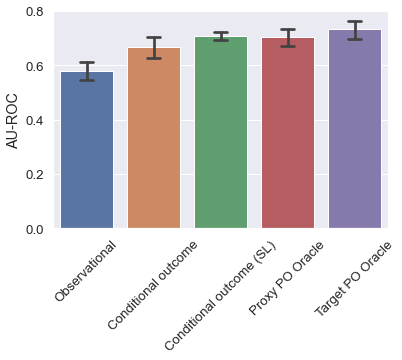

In [22]:
sns.set(font_scale=1.2)
g=sns.barplot(data=resdf, x='model', y='AU-ROC', capsize=.2)
plt.xticks(rotation=45)
plt.ylabel('AU-ROC')
plt.xlabel('')

Text(0.5, 0, '')

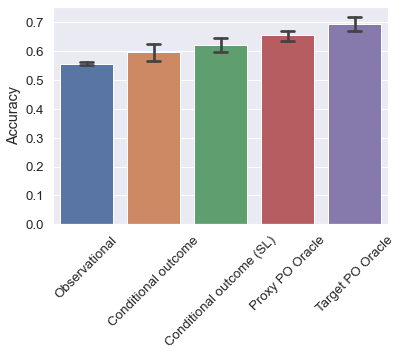

In [13]:
resdf = pd.read_csv('results/exp1_results_NR_20_NS_3000_E=10.csv')

sns.set(font_scale=1.2)
g=sns.barplot(data=resdf, x='model', y='ACC', capsize=.2)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('')

In [23]:
resdf.groupby('model').std()

,AU-ROC,ACC
model,,
Conditional outcome,0.091218,0.066475
Conditional outcome (SL),0.035400,0.057351
Observational,0.075568,0.013199
Proxy PO Oracle,0.068751,0.037389
Target PO Oracle,0.077950,0.059040


In [20]:
print(resdf.groupby('model').mean().to_latex())

\begin{tabular}{lrr}
\toprule
{} &    AU-ROC &       ACC \\
model                    &           &           \\
\midrule
Conditional outcome      &  0.668448 &  0.596222 \\
Conditional outcome (SL) &  0.707192 &  0.622833 \\
Observational            &  0.577547 &  0.555778 \\
Proxy PO Oracle          &  0.704853 &  0.654111 \\
Target PO Oracle         &  0.732189 &  0.694667 \\
\bottomrule
\end{tabular}



/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_90379/48772518.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(resdf.groupby('model').mean().to_latex())


## Main Experiment: parameter estimation via CCPE

In [ ]:
SAMPLE_SIZES = [1000, 5000, 10000, 20000]
exp_results, py_results = ccpe_benchmark_exp(SAMPLE_SIZES, N_RUNS=5, K=3, n_epochs=20)
result_df = get_ccpe_result_df(do=1, exp_results=exp_results)


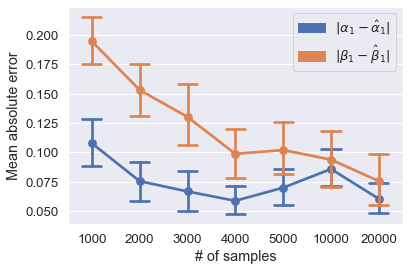

In [70]:
result_df = pd.read_csv('results/R6_K=1_N_RUNS=100_n_epochs=40_d0.csv')
result_df = result_df[result_df['aggregate'] == False]
g = sns.pointplot(
    data=result_df,
    x='NS',
    y='error',
    hue='parameter',
    capsize=.4,
    legend=True
)
g.set(xlabel='# of samples', ylabel='Mean absolute error')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color=sns.color_palette()[0], label=r'$|\alpha_1 - \hat{\alpha}_1|$')
black_patch = mpatches.Patch(color=sns.color_palette()[1], label=r'$|\beta_1 - \hat{\beta}_1|$')
plt.legend(handles=[red_patch, black_patch])

plt.savefig('figs/estimation_error.png', dpi=500)


In [38]:
plt.savefig('estimation_error.png', dpi=500)

<Figure size 432x288 with 0 Axes>

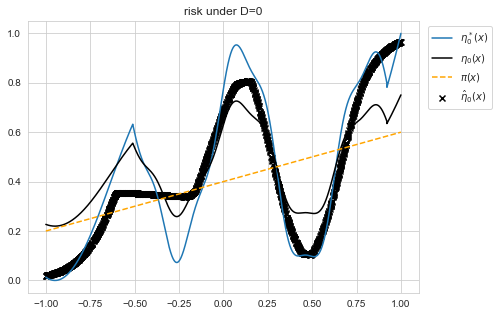

In [25]:
do=0
debug_info = {
    'val_x': results2['x'],
    'val_py': results2['py_hat']
}
viz_ccpe_estimates(expdf, debug_info, error_params[f'alpha_{do}'][0],
                   error_params[f'beta_{do}'][0], do, Y0_PDF, Y1_PDF, PI_PDF)


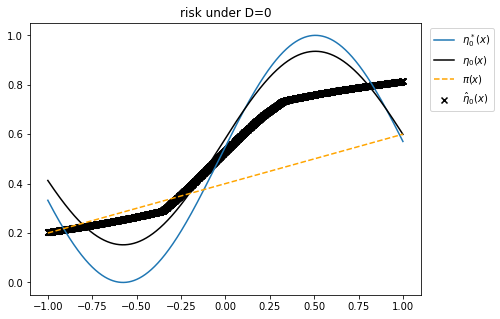

In [114]:
# Possibly create a helper function here for plotting resuls of experiments

params = { 'alpha': None, 'alpha_0': 0.15228761, 'beta': None, 'beta_0': 0.06452641 }

do=0
debug_info = {
    'val_x': py_results[8000][0][0][0]['x'],
    'val_py': py_results[8000][0]['eta_0_bar']
}
expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.05,
    error_max=0.25
)

viz_ccpe_estimates(expdf, debug_info, params, do, Y0_PDF, Y1_PDF, PI_PDF)


## Experiment: Robustness to parameter estimation Error

In [46]:
alphas = [0,  .1, .2, .3, .4]
betas = [0, .1, .2,  .3,  .4]
error_mag = [.01, .05, .1, .2, .3]
configs = []

for alpha in alphas:
    for beta in betas:
        for error in error_mag:
            if alpha+beta < .5:
                configs.append({
                    'alpha_true': alpha,
                    'beta_true': beta,
                    'alpha_hat': error,
                    'beta_hat': error
                })

In [58]:
params = [{
    'alpha': .1,
    'beta': .1,
    'alpha_hat': 0,
    'beta_hat': 0
},{
    'alpha': .1,
    'beta': .1,
    'alpha_hat': 0,
    'beta_hat': 0.2
},{
    'alpha': .1,
    'beta': .1,
    'alpha_hat': 0.05,
    'beta_hat': 0.4
},{
    'alpha': .1,
    'beta': .1,
    'alpha_hat': .1,
    'beta_hat': .1
}]

baselines = [{
    'model': 'Conditional outcome',
    'target': 'Y0'
},{
    'model': 'Conditional outcome (SL)',
    'target': 'Y0'
}]

results = []

for param_config in params:
    expdf, error_params = generate_syn_data(
        NS=5000,
        K=1,
        y0_pdf=Y0_PDF,
        y1_pdf=Y1_PDF,
        pi_pdf=PI_PDF,
        error_min=param_config['alpha']-.001,
        error_max=param_config['alpha']+.001,
        shuffle=True
    )
    
    for baseline in baselines:
        
        if baseline['model'] == 'Conditional outcome (SL)':
            surrogate = {
                'alpha': param_config['alpha_hat'],
                'beta': param_config['beta_hat']
            }
        
        else:
            surrogate = {
                'alpha': None,
                'beta': None
            }

        result = run_baseline(expdf, baseline, do=0,
                              surrogate_params=surrogate, n_epochs=5, train_ratio=.7)
        
        result['model'] = baseline['model']
        result['alpha_error'] = abs(param_config['alpha'] - param_config['alpha_hat'])
        result['beta_error'] = abs(param_config['beta'] - param_config['beta_hat'])
        result['alpha'] = param_config['alpha']
        result['beta'] = param_config['beta']

        results.append(result)




Target: Y0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]


In [44]:
params = [{
    'alpha': .1,
    'beta': .1
},{
    'alpha': .1,
    'beta': .3
},{
    'alpha': .2, #actual values#
    'beta': .2
},{
    'alpha': .2,
    'beta': .4
},{
    'alpha': .05,
    'beta': .4
}]
t = [result['ACC'] for result in results]
t

NameError: name 'results' is not defined

In [ ]:
def get_noisy_params(true_params, do, eps):
    
    alpha_true = error_params[f'alpha_{do}']
    beta_true = error_params[f'beta_{do}']
    random.sample([-1, 1], 1)[0] * eps

In [11]:
Y0_PDF = 'sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'


baseline = {
    'model': 'Conditional outcome (SL)',
    'target': 'Y0'
}
        
exp_results = {
    'model': [],
    'AU-ROC': [],
    'ACC': []
}

for config in param_configs:
    
    for RUN in range(N_RUNS):
        expdf, error_params = generate_syn_data(
            NS,
            K,
            y0_pdf=Y0_PDF,
            y1_pdf=Y1_PDF,
            pi_pdf=PI_PDF,
            error_min=0.05,
            error_max=0.25
        )
        
        target = baseline['target']

        run_baseline(expdf, baseline, do, surrogate_params, n_epochs=5, train_ratio=.7)


NameError: name 'param_configs' is not defined

In [ ]:
def run_estimation_error_exp(expdf, do, error_params, n_epochs=5, train_ratio=.7):

    expdf = expdf.sample(frac=1).reset_index(drop=True)
    split_ix = int(expdf.shape[0]*train_ratio)
    train_df, val_df = expdf.iloc[:split_ix,:], expdf.iloc[split_ix:,:]
    
    exp_results = {
        'noise_rate': [],
        'AU-ROC': []
    }
    
    targets = ['YD']
    val_scores = {}
    
    for surrogate_params in param_configs:
        
        train_loader, val_loader = get_loaders(train_df, val_df, do, target)
        model = MLP()
        losses = train(model, train_loader, error_params=surrogate_params, n_epochs=n_epochs)
        x, y, py_hat = evaluate(model, val_loader)
        auroc = roc_auc_score(y, py_hat)

        exp_results['noise_rate'].append(surrogate_params['alpha']+surrogate_params['beta'])
        exp_results['AU-ROC'].append(auroc)
        
        val_scores[target] = {}
        val_scores[target]['x'] = x
        val_scores[target]['y'] = y
        val_scores[target]['py_hat'] = py_hat

    return exp_results, val_scores

run_estimation_error_exp(expdf, do, error_params,
                         n_epochs=5, train_ratio=.7)

sns.barplot(data=resultdf, x='model', y='AU-ROC')

## Visualize class probability estimates

Target: YS_0: 100%|█████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]


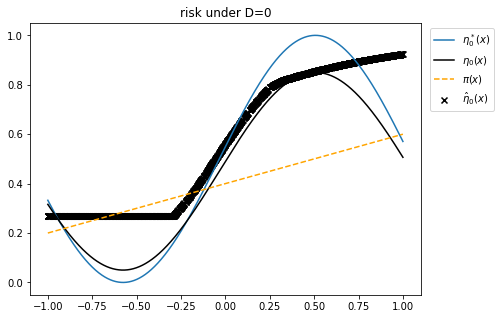

In [19]:
params = { 'alpha': None, 'alpha_0': .05, 'beta': None, 'beta_0': .15 }
baseline = {
    'model': 'Target PO Oracle',
    'target': 'YS_0'
    
}

results = run_baseline(expdf, baseline, do, params,
             n_epochs=10, train_ratio=.7)

do=0
debug_info = {
    'val_x': results['x'],
    'val_py': results['py_hat']
}

viz_ccpe_estimates(expdf, debug_info, params, do, Y0_PDF, Y1_PDF, PI_PDF)


### Debugging baselines

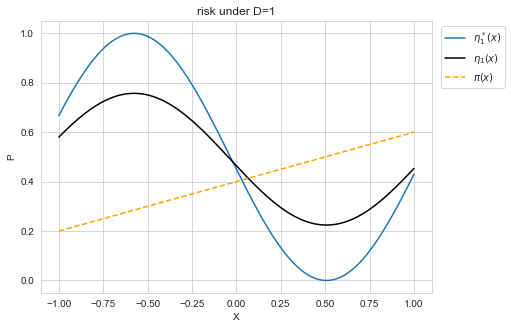

In [2]:
Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'
do=1

expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.20,
    error_max=0.25
)

debug_info = {
    'val_x': None,
    'val_py': None
}

viz_ccpe_estimates(expdf, debug_info, error_params[f'alpha_{do}'][0],
                   error_params[f'beta_{do}'][0], do, Y0_PDF, Y1_PDF, PI_PDF)

In [8]:
## Main Experiment: troubleshoot baselines

Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'uniform'
do=1

expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.20,
    error_max=0.2005, 
    shuffle=True
)


baseline1 = {
    'model': 'Conditional outcome',
    'target': 'Y0'
}

baseline2 = {
    'model': 'Conditional outcome (SL)',
    'target': 'Y0'
}

params1 = {
    'alpha': None,
    'beta': None
}

params2 = {
    'alpha': 0.2,
    'beta': 0.2
}

co = run_baseline(expdf, baseline1, do, params1, n_epochs=40, train_ratio=.7)
cosl = run_baseline(expdf, baseline2, do, params2, n_epochs=40, train_ratio=.7)



Target: Y0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:27<00:00,  1.45it/s]


In [51]:
expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.20,
    error_max=0.2005, 
    shuffle=True
)

split_ix = int(expdf.shape[0]*.7)
train_df, val_df = expdf.iloc[:split_ix,:], expdf.iloc[split_ix:,:]


# Train model
train_loader, val_loader = get_loaders(train_df, val_df, do=1, target='Y0', conditional=True)
model = MLP()

surrogate_params = {
    'alpha': 0.2,
    'beta': 0.2
}

# surrogate_params = {
#     'alpha': None,
#     'beta': None
# }

losses = train(model, target='Y0', train_loader=train_loader, error_params=surrogate_params, n_epochs=40)

# Evaluate on validation data
x, y, py_hat = evaluate(model, val_loader)
y_hat = np.zeros_like(y)
y_hat[py_hat > .5] = 1

Target: Y0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:28<00:00,  1.41it/s]


In [52]:


def get_loss_1(y_hat, y, alpha_d=None, beta_d=None):

    loss = torch.nn.BCELoss()
    if not alpha_d:
        return loss(y_hat, y) 

    
    # Next session -- try re-implementing this loss function again and carefully debug
    # If loss is correct then learned curve should be at target PO
    pos_loss = loss(y_hat[y==1], y[y==1])
    neg_loss = loss(y_hat[y==0], y[y==0])

    pos_label_losses = ((1-alpha_d)*pos_loss - beta_d*neg_loss)/(1-beta_d-alpha_d)
    neg_label_losses = ((1-beta_d)*neg_loss - alpha_d*pos_loss)/(1-beta_d-alpha_d)

    return pos_label_losses + neg_label_losses

def get_loss_2(y_hat, y, alpha_d=None, beta_d=None)


In [39]:
loss_func = torch.nn.BCELoss()
loss_func(y_hat.squeeze(), y.squeeze())

TypeError: 'int' object is not callable

In [ ]:
loss = get_loss(outputs, y, error_params['alpha'], error_params['beta'])



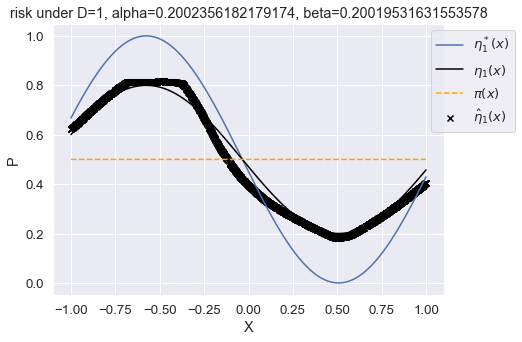

In [54]:
Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'uniform'
do=1

expdf, error_params = generate_syn_data(
    NS=10000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.20,
    error_max=0.2005
)
# debug_info = {
#     'val_x': cosl['x'].squeeze(),
#     'val_py': cosl['py_hat'].squeeze()
# }
debug_info = {
    'val_x': x,
    'val_py': py_hat
}
sns.set(font_scale=1.2)
viz_ccpe_estimates(expdf, debug_info, error_params[f'alpha_{do}'][0],
                   error_params[f'beta_{do}'][0], do, Y0_PDF, Y1_PDF, PI_PDF)


In [23]:
def get_loss(y_hat, y, alpha_d=None, beta_d=None):

    loss = torch.nn.BCELoss()
    if not alpha_d:
        return loss(y_hat, y) 

    pos_loss = loss(y_hat[y==1], y[y==1])
    neg_loss = loss(y_hat[y==0], y[y==0])

    pos_label_losses = ((1-alpha_d)*pos_loss - beta_d*neg_loss)/(1-beta_d-alpha_d)
    neg_label_losses = ((1-beta_d)*neg_loss - alpha_d*pos_loss)/(1-beta_d-alpha_d)

    return pos_label_losses + neg_label_losses
